# Performing a parameter sweep

The objective of this task is to optimize the parameters of the BM25 retrieval model (b and k1) in a systematic way. 

The proper solution would be to do an extensive grid search, as b and k1 are not independent of each other. The pseudo code for that would look something like:

```
for b between 0 and 1 in 0.1 steps
    for k between 1 and 2 in 0.1 steps
        perform retrieval using b and k
        evaluate
pick b and k with highest overall performance (MAP score)
```

As this would take a lot of time, what we do instead in this exercise is the following:
  - keep the default k1 value (1.2) and perform a sweep on b
  - use the best performing b value and perform a sweep on k1
  
This may not be a global optimum, but should give better results than the default setting.

**NOTE** The solution is incomplete; those parts of the code that should be developed as part of Assignment 1 are removed.

In [19]:
from elasticsearch import Elasticsearch
import time

In [14]:
INDEX_NAME = "aquaint"
DOC_TYPE = "doc"
FIELD = "content"

In [3]:
QUERY_FILE = "data/queries.txt"
OUTPUT_FILE = "data/baseline.txt"
QRELS_FILE = "data/qrels2.csv"

In [6]:
def load_queries(query_file):
    queries = {}
    with open(query_file, "r") as fin:
        for line in fin.readlines():
            qid, query = line.strip().split(" ", 1)
            queries[qid] = query
    return queries

In [7]:
def eval_query(ranking, gt):
    # See Assignment 1
    pass

In [8]:
def eval(gt_file, output_file):
    
    # See Assignment 1
    # This function is modified such that it only returns the MAP score
    pass

In [9]:
queries = load_queries(QUERY_FILE)

In [10]:
es = Elasticsearch()

### Perform a sweep on b

In [2]:
map_scores = []
x = []
for i in range(11):
    b = round(i / 10, 2) 
    x.append(b)
    print("Running queries for b=%f" % b)
    SIM = {
        "similarity": {
            "default": { 
                "type": "BM25",
                "b": b,
                "k1": 1.2
            }
        }
    }

    # change params
    es.indices.close(index=INDEX_NAME)
    es.indices.put_settings(index=INDEX_NAME, body=SIM)
    es.indices.open(index=INDEX_NAME)
    # need to wait a bit before firing queries
    time.sleep(1)

    # run retrieval and write it to a file (so that we can easily reuse previous code)
    with open(OUTPUT_FILE, "w") as fout:
        # write header
        fout.write("QueryId,DocumentId\n")
        for qid, query in queries.items():
            res = es.search(index=INDEX_NAME, q=query, df=FIELD, _source=False, size=100).get("hits", {})
            for doc in res.get("hits", {}):
                fout.write(qid + "," + doc.get("_id") + "\n")    
    
    # evaluate
    map_score = eval(QRELS_FILE, OUTPUT_FILE)
    map_scores.append(map_score)

Running queries for b=0.000000
Running queries for b=0.100000
Running queries for b=0.200000
Running queries for b=0.300000
Running queries for b=0.400000
Running queries for b=0.500000
Running queries for b=0.600000
Running queries for b=0.700000
Running queries for b=0.800000
Running queries for b=0.900000
Running queries for b=1.000000


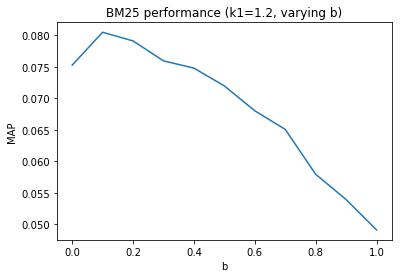

In [50]:
import matplotlib.pyplot as plt

plt.plot(x, map_scores)
plt.title("BM25 performance (k1=1.2, varying b)")
plt.xlabel("b")
plt.ylabel("MAP")
plt.savefig("bm25_b_sweep.png")
plt.show()

### Perform a sweep on k1

We use the best performing b value from above (0.1) and optimize k1

In [4]:
map_scores = []
x = []
for i in range(11):
    k1 = 1 + round(i / 10, 2) 
    x.append(k1)
    print("Running queries for k1=%f" % k1)
    SIM = {
        "similarity": {
            "default": { 
                "type": "BM25",
                "b": 0.1,
                "k1": k1
            }
        }
    }

    # change params
    es.indices.close(index=INDEX_NAME)
    es.indices.put_settings(index=INDEX_NAME, body=SIM)
    es.indices.open(index=INDEX_NAME)
    # need to wait a bit before firing queries
    time.sleep(1)

    # run retrieval and write it to a file (so that we can easily reuse previous code)
    with open(OUTPUT_FILE, "w") as fout:
        # write header
        fout.write("QueryId,DocumentId\n")
        for qid, query in queries.items():
            #print("Ranking documents for [%s] '%s'" % (qid, query))
            res = es.search(index=INDEX_NAME, q=query, df=FIELD, _source=False, size=100).get("hits", {})
            for doc in res.get("hits", {}):
                fout.write(qid + "," + doc.get("_id") + "\n")    

    # evaluate
    map_score = eval(QRELS_FILE, OUTPUT_FILE)    
    map_scores.append(map_score)

Running queries for k1=1.000000
Running queries for k1=1.100000
Running queries for k1=1.200000
Running queries for k1=1.300000
Running queries for k1=1.400000
Running queries for k1=1.500000
Running queries for k1=1.600000
Running queries for k1=1.700000
Running queries for k1=1.800000
Running queries for k1=1.900000
Running queries for k1=2.000000


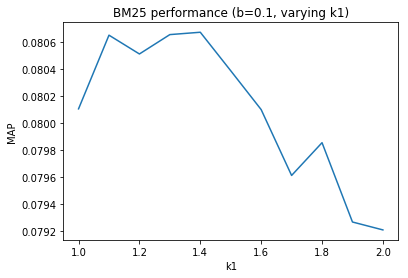

In [48]:
plt.plot(x, map_scores)
plt.title("BM25 performance (b=0.1, varying k1)")
plt.xlabel("k1")
plt.ylabel("MAP")
plt.savefig("bm25_k1_sweep.png")
plt.show()